In [1]:
%env CUDA_VISIBLE_DEVICES 4

env: CUDA_VISIBLE_DEVICES=4


In [2]:
import matplotlib.pyplot as plt
from omegaconf import OmegaConf
from paintmind.engine.util import instantiate_from_config
import torch

from paintmind.stage1.diffuse_slot import DiffuseSlot
from safetensors import safe_open

In [3]:
ckpt = {}
# with safe_open('/mnt/ceph_rbd/wx/work/slot_ar/output/'
#                'dit_ffhq256_2500ep_nest_after1500_32bs/models/step600000/model.safetensors',
# with safe_open('/mnt/ceph_rbd/zbc/slot_ar/output/imagenet820k.safetensors',
# with safe_open('/disk/scratch_big/bingchen/dataset/semanticist_ckpts/imagenet100_990k.safetensors',
with safe_open('/disk/scratch_big/bingchen/dataset/semanticist_ckpts/ffhq600k.safetensors',
               framework='pt', 
               device='cpu') as f:
    for key in f.keys():
        ckpt[key] = f.get_tensor(key)

In [4]:
ckpt.keys()

dict_keys(['dit.autoenc_cond_embedder.bias', 'dit.autoenc_cond_embedder.weight', 'dit.blocks.0.adaLN_modulation.1.bias', 'dit.blocks.0.adaLN_modulation.1.weight', 'dit.blocks.0.attn.proj.bias', 'dit.blocks.0.attn.proj.weight', 'dit.blocks.0.attn.qkv.bias', 'dit.blocks.0.attn.qkv.weight', 'dit.blocks.0.mlp.fc1.bias', 'dit.blocks.0.mlp.fc1.weight', 'dit.blocks.0.mlp.fc2.bias', 'dit.blocks.0.mlp.fc2.weight', 'dit.blocks.1.adaLN_modulation.1.bias', 'dit.blocks.1.adaLN_modulation.1.weight', 'dit.blocks.1.attn.proj.bias', 'dit.blocks.1.attn.proj.weight', 'dit.blocks.1.attn.qkv.bias', 'dit.blocks.1.attn.qkv.weight', 'dit.blocks.1.mlp.fc1.bias', 'dit.blocks.1.mlp.fc1.weight', 'dit.blocks.1.mlp.fc2.bias', 'dit.blocks.1.mlp.fc2.weight', 'dit.blocks.10.adaLN_modulation.1.bias', 'dit.blocks.10.adaLN_modulation.1.weight', 'dit.blocks.10.attn.proj.bias', 'dit.blocks.10.attn.proj.weight', 'dit.blocks.10.attn.qkv.bias', 'dit.blocks.10.attn.qkv.weight', 'dit.blocks.10.mlp.fc1.bias', 'dit.blocks.10.mlp.

In [5]:
keys = ['encoder2slot.bias', 'encoder2slot.weight', 'grouping.slot_embed.weight', 'nested_sampler.arange', 
'nested_sampler.attn.in_proj_bias', 'nested_sampler.attn.in_proj_weight', 'nested_sampler.attn.out_proj.bias', 
'nested_sampler.attn.out_proj.weight', 'nested_sampler.slot2attn.bias', 'nested_sampler.slot2attn.weight', 'sampler_latents',]

In [6]:
for key in keys:
    print(key, ckpt[key].shape)

encoder2slot.bias torch.Size([12])
encoder2slot.weight torch.Size([12, 768, 1, 1])
grouping.slot_embed.weight torch.Size([64, 12])
nested_sampler.arange torch.Size([64])
nested_sampler.attn.in_proj_bias torch.Size([36])
nested_sampler.attn.in_proj_weight torch.Size([36, 12])
nested_sampler.attn.out_proj.bias torch.Size([12])
nested_sampler.attn.out_proj.weight torch.Size([12, 12])
nested_sampler.slot2attn.bias torch.Size([12])
nested_sampler.slot2attn.weight torch.Size([12, 12])
sampler_latents torch.Size([64, 12])


In [7]:
num_samplers = 128
sampler_dim = 8
num_slots = 128
slot_dim = 8

In [8]:
# cfg = OmegaConf.load('configs/imagenet100_cache.yaml')
# cfg = OmegaConf.load('/mnt/ceph_rbd/zbc/slot_ar/configs/dit_clevr4.yaml')
cfg = OmegaConf.load('configs/ffhq1264.yaml')

In [9]:
from paintmind.data.coco import vae_transforms
from PIL import Image

transform = vae_transforms('test')


def norm_ip(img, low, high):
    img.clamp_(min=low, max=high)
    img.sub_(low).div_(max(high - low, 1e-5))

def norm_range(t, value_range):
    if value_range is not None:
        norm_ip(t, value_range[0], value_range[1])
    else:
        norm_ip(t, float(t.min()), float(t.max()))

from PIL import Image
def convert_np(img):
    ndarr = img.mul(255).add_(0.5).clamp_(0, 255)\
            .permute(1, 2, 0).to("cpu", torch.uint8).numpy()
    return ndarr
def convert_PIL(img):
    ndarr = img.mul(255).add_(0.5).clamp_(0, 255)\
            .permute(1, 2, 0).to("cpu", torch.uint8).numpy()
    img = Image.fromarray(ndarr)
    return img


In [10]:
model = DiffuseSlot(**cfg['trainer']['params']['model']['params'])
msg = model.load_state_dict(ckpt, strict=False)
model.cuda();

/disk/scratch_fast/bingchen/slot_ar/paintmind/stage1/diffuse_slot.py:346: FutureWarning: Accessing config attribute `scaling_factor` directly via 'AutoencoderKL' object attribute is deprecated. Please access 'scaling_factor' over 'AutoencoderKL's config object instead, e.g. 'unet.config.scaling_factor'.
  self.scaling_factor = self.vae.scaling_factor
/disk/scratch_fast/bingchen/slot_ar/paintmind/stage1/dinov2_layers/swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
/disk/scratch_fast/bingchen/slot_ar/paintmind/stage1/dinov2_layers/attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
/disk/scratch_fast/bingchen/slot_ar/paintmind/stage1/dinov2_layers/block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")


In [11]:
print(msg)

<All keys matched successfully>


In [12]:
model.eval();

In [13]:
# img = Image.open('/disk/scratch_fast/bingchen/imagenet100/train/n01518878/n01518878_10006.JPEG')
img = Image.open('/disk/scratch_big/bingchen/dataset/ffhq/images256x256/00100.png')

In [14]:
img, _ = transform(img, None)
img = img.cuda().unsqueeze(0)

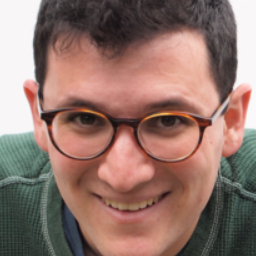

In [15]:
convert_PIL(img[0].cpu())

In [16]:
@torch.no_grad()
def get_model_pred(img, n_slots=64, ddim=True):
    slots, _ = model.encode_slots(img.to('cuda'))
    sampled_from_slots = model.sample_from_slots(
        slots, 
        slots.device, 
        inference_with_n_slots=n_slots, 
        ddim=True
    )
    return sampled_from_slots, slots

In [17]:
output, slots = get_model_pred(img, n_slots=4, ddim=True)

  0%|          | 0/100 [00:00<?, ?it/s]

In [18]:
@torch.no_grad()
def get_slots(img):
    slots, _ = model.encode_slots(img.to('cuda'))
    return slots

In [19]:
from glob import glob
class ffhq_dataset:
    def __init__(self):
        self.data_path = glob('/disk/scratch_big/bingchen/dataset/ffhq/images256x256/*.png')
    def __len__(self):
        return len(self.data_path)
    def __getitem__(self, idx):
        img = Image.open(self.data_path[idx])
        img, _ = transform(img, None)
        return img

In [20]:
ds = ffhq_dataset()
dl = torch.utils.data.DataLoader(ds, batch_size=32, shuffle=False)

In [21]:
from tqdm.notebook import tqdm

In [22]:
all_slots = []
for imgs in tqdm(dl):
    slots = get_slots(imgs)
    all_slots.append(slots.cpu())
all_slots = torch.cat(all_slots, dim=0)

  0%|          | 0/2188 [00:00<?, ?it/s]

In [24]:
torch.save(all_slots, '/disk/scratch_big/bingchen/dataset/ffhq/ffhq_slots.pt')

In [29]:
import facer

In [30]:
image = facer.hwc2bchw(
    facer.read_hwc("/disk/scratch_big/bingchen/dataset/ffhq/images256x256/00000.png")
).to('cuda')

In [32]:
face_detector = facer.face_detector("retinaface/mobilenet", device='cuda')
with torch.inference_mode():
    faces = face_detector(image)

Downloading: "https://github.com/elliottzheng/face-detection/releases/download/0.0.1/mobilenet0.25_Final.pth" to /afs/inf.ed.ac.uk/user/s23/s2329503/.cache/torch/hub/checkpoints/mobilenet0.25_Final.pth
100%|██████████| 1.71M/1.71M [00:00<00:00, 14.4MB/s]


In [34]:
face_attr = facer.face_attr("farl/celeba/224", device='cuda')
with torch.inference_mode():
    faces = face_attr(image, faces)

Downloading: "https://github.com/FacePerceiver/facer/releases/download/models-v1/face_attribute.farl.celeba.pt" to /afs/inf.ed.ac.uk/user/s23/s2329503/.cache/torch/hub/checkpoints/face_attribute.farl.celeba.pt
100%|██████████| 327M/327M [00:25<00:00, 13.5MB/s] 


In [36]:
labels = face_attr.labels
face1_attrs = faces["attrs"][0] # get the first face's attributes

print(labels)

['5_o_Clock_Shadow', 'Arched_Eyebrows', 'Attractive', 'Bags_Under_Eyes', 'Bald', 'Bangs', 'Big_Lips', 'Big_Nose', 'Black_Hair', 'Blond_Hair', 'Blurry', 'Brown_Hair', 'Bushy_Eyebrows', 'Chubby', 'Double_Chin', 'Eyeglasses', 'Goatee', 'Gray_Hair', 'Heavy_Makeup', 'High_Cheekbones', 'Male', 'Mouth_Slightly_Open', 'Mustache', 'Narrow_Eyes', 'No_Beard', 'Oval_Face', 'Pale_Skin', 'Pointy_Nose', 'Receding_Hairline', 'Rosy_Cheeks', 'Sideburns', 'Smiling', 'Straight_Hair', 'Wavy_Hair', 'Wearing_Earrings', 'Wearing_Hat', 'Wearing_Lipstick', 'Wearing_Necklace', 'Wearing_Necktie', 'Young']


In [45]:
ffhq_images = sorted(glob('/disk/scratch_big/bingchen/dataset/ffhq/images256x256/*.png'))

In [46]:
def get_facer_attr(img_path):
    image = facer.hwc2bchw(
        facer.read_hwc(img_path)
    ).to('cuda')
    with torch.inference_mode():
        faces = face_detector(image)
        faces = face_attr(image, faces)
    attr_dict = {label: prob.item() for label, prob in zip(labels, faces['attrs'][0])}
    return attr_dict

In [47]:
attr_dict = get_facer_attr(ffhq_images[0])

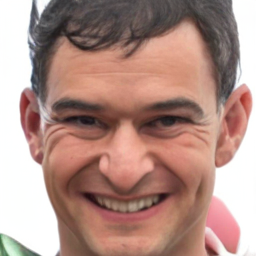

In [51]:
convert_PIL(output[0].cpu())

In [52]:
def get_facer_attr_from_tensor(img):
    # img is already in bchw format, that is, 1, 3, 224, 224
    image = img.to('cuda')
    with torch.inference_mode():
        faces = face_detector(image)
        faces = face_attr(image, faces)
    attr_dict = {label: prob.item() for label, prob in zip(labels, faces['attrs'][0])}
    return attr_dict

In [54]:
attr_dict = get_facer_attr_from_tensor(output * 255)

In [56]:
len(attr_dict)

40